## Imports

In [88]:
import pandas as pd
import numpy as np

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder
)

## Dataset

In [45]:
df = pd.read_csv("./data/star_classification.csv", dtype={0: 'int64'})
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1237660961327743232,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1237664879951151104,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1237660961330430208,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1237663478724297984,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1237680272041378048,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### Resumo

Os dados consistem em 100.000 observações do espaço obtidas pelo SDSS (Sloan Digital Sky Survey). Cada observação é descrita por 17 colunas de características e 1 coluna de classe que a identifica como uma estrela, galáxia ou quasar.

obj_ID = Object Identifier, valor único que identifica o objeto no catálogo de imagens utilizado pelo CAS

alfa = Ângulo de ascensão reta (na época J2000)

delta = Ângulo de declinação (na época J2000)

u = Filtro ultravioleta no sistema fotométrico

g = Filtro verde no sistema fotométrico

r = Filtro vermelho no sistema fotométrico

i = Filtro infravermelho próximo no sistema fotométrico

z = Filtro infravermelho no sistema fotométrico

run_ID = Número de execução usado para identificar a verificação específica

rereun_ID = Número de nova execução para especificar como a imagem foi processada

cam_col = Coluna da câmera para identificar a linha de varredura na execução

field_ID = Número do campo para identificar cada campo

spec_obj_ID = ID exclusivo usado para objetos espectroscópicos ópticos (isso significa que 2 observações diferentes com o mesmo spec_obj_ID devem compartilhar a classe de saída)

class = classe do objeto (objeto galáxia, estrela ou quasar)

redshift = valor do redshift com base no aumento do comprimento de onda

plate = ID do plate, identifica cada plate no SDSS

MJD = Data Juliana Modificada, usada para indicar quando um determinado dado do SDSS foi obtido

Fiber_ID = ID da fibra que identifica a fibra que apontou a luz para o plano focal em cada observação

## Limpeza e Tratamento

Excluindo coluna com ID do objeto porque não será utilizada para classificação visto que o ID é um identificador único para cada objeto

In [46]:
df.drop("obj_ID", axis=1, inplace=True)

Verificando estatísticas

In [47]:
df.describe()

,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


Excluindo coluna "rerun_ID", pois seu desvio padrão é 0

In [48]:
df.drop("rerun_ID", axis=1, inplace=True)

Verificando quantidade de valores únicos de cada coluna

In [49]:
df.nunique()

alpha           99999
delta           99999
u               93748
g               92651
r               91901
i               92019
z               92007
run_ID            430
cam_col             6
field_ID          856
spec_obj_ID    100000
class               3
redshift        99295
plate            6284
MJD              2180
fiber_ID         1000
dtype: int64

In [50]:
df.isnull().sum()

alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

## Análise Exploratória de Dados

### Correlação com Classes

In [132]:
df_aed = df.copy()

In [97]:
ohe = OneHotEncoder()

In [141]:
values_enc = ohe.fit_transform(df_aed["class"].values.reshape(-1, 1)).toarray()

cols_class = ohe.categories_[0]

In [143]:
df_aed[cols_class] = values_enc

In [161]:
df_corr = df_aed.drop("class", axis=1).corr().abs()

In [162]:
df_corr_galaxy = df_corr["GALAXY"]
df_corr_star = df_corr["STAR"]
df_corr_qso = df_corr["QSO"]

In [165]:
df_corr_qso.sort_values(ascending=False)

QSO            1.000000
redshift       0.756649
GALAXY         0.585624
i              0.370459
spec_obj_ID    0.295908
plate          0.295908
MJD            0.277872
r              0.255142
STAR           0.253849
fiber_ID       0.071813
delta          0.065825
field_ID       0.026760
run_ID         0.024948
z              0.024361
alpha          0.014261
u              0.006590
g              0.006015
cam_col        0.003317
Name: QSO, dtype: float64

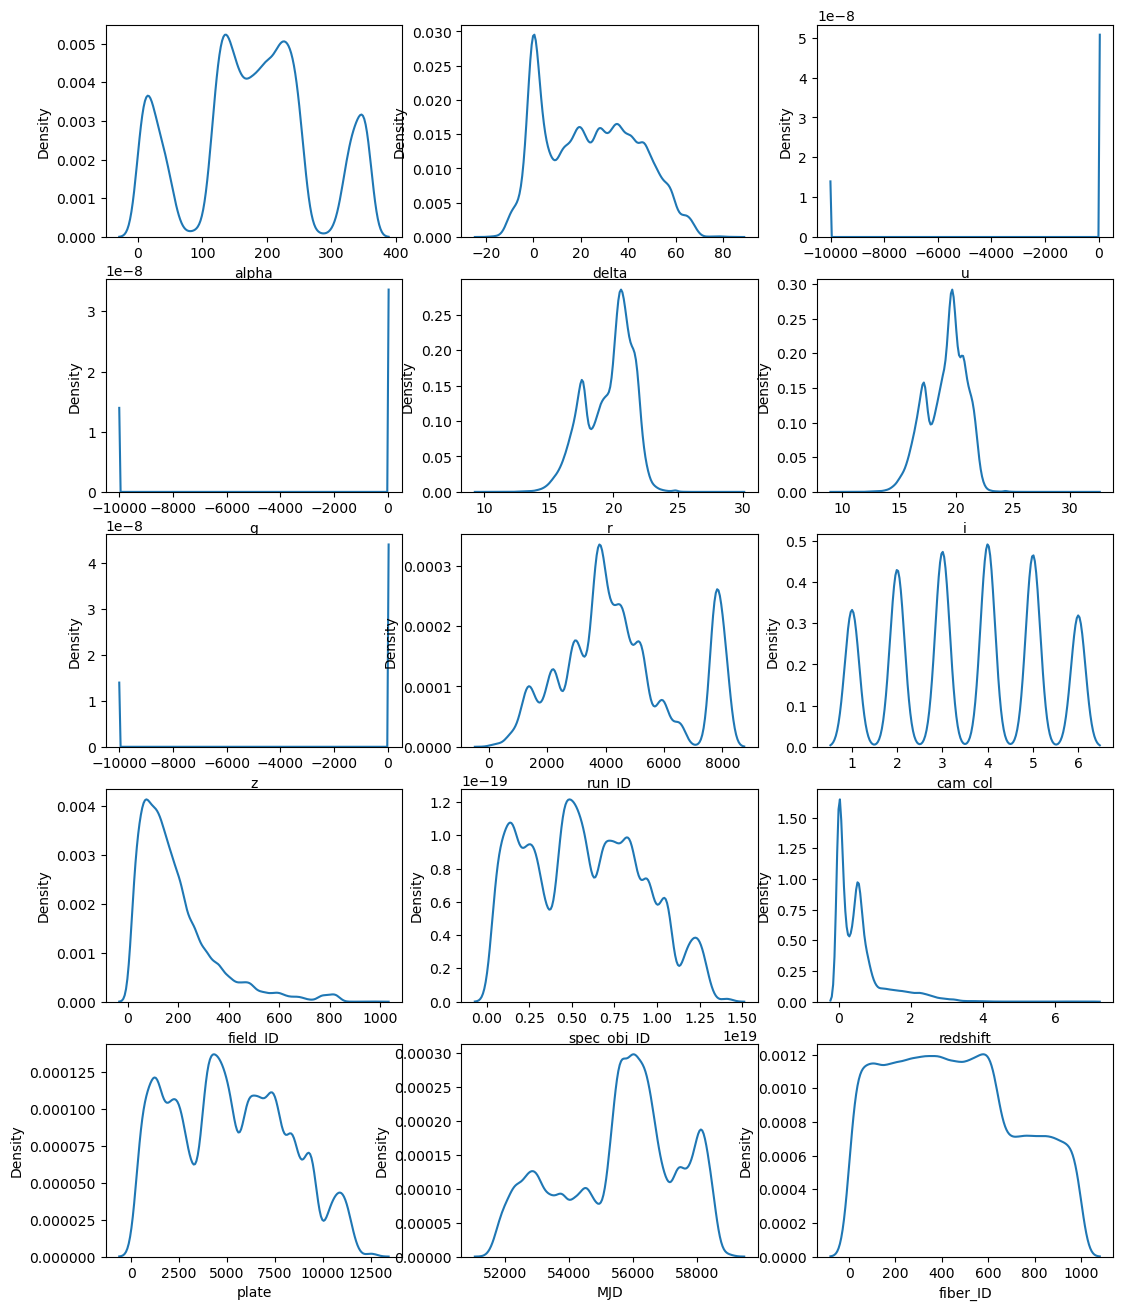

In [146]:
fig, axs = plt.subplots(5, 3, figsize=(13, 16))

cols = df_aed.drop(["class", "GALAXY", "QSO", "STAR"], axis=1).columns

for i, col in enumerate(cols):
    
    sns.kdeplot(df_aed[col], ax=axs[i // 3, i % 3])

In [54]:
df

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470
